In [2]:
from scipy.stats import norm, expon
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

url = "https://raw.githubusercontent.com/jealcalat/AEM-ITESO/main/datasets/booking_days.csv"

data = pd.read_csv(url)['days']

all_days = data.values

In [3]:
 # definir la función de verosimilitud (log-verosim negativa)
    
def neg_log_mix(theta, all_days):
    rate, mean, std, w = theta
    l_exec = expon.pdf(all_days, scale=1/rate)
    l_vaca = norm.pdf(all_days, mean, std)
    mix = w * l_exec + (1-w) * l_vaca
    log_mix = np.log(mix + 1e-90)
    return -np.sum(log_mix)

res = minimize(
        neg_log_mix,
        [0.1, 90, 10, 0.45],
        bounds=[(0.0001, None),(5, 400), (1, 40), (0, 1)],
        args=(all_days)
)

res.x.round(3)

array([1.01000e-01, 1.20729e+02, 2.91300e+01, 4.99000e-01])

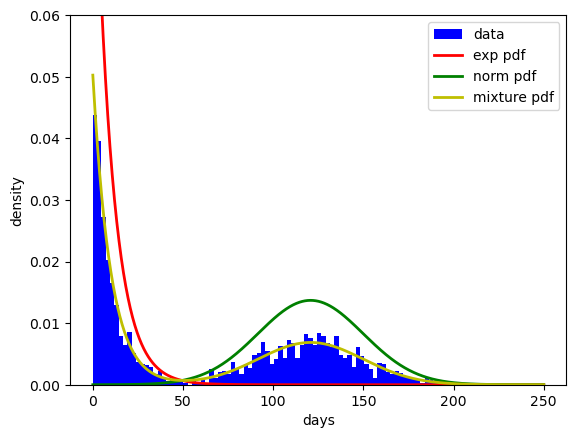

In [4]:
plt.hist(all_days, bins=90, density=True, color='blue', label='data');
x = np.linspace(0, 250, 1000)
rate, mean, std, w = res.x
exp_pdf = expon.pdf(x, scale=1/rate)
norm_pdf = norm.pdf(x, mean, std)
mix_pdf = w * exp_pdf + (1 - w) * norm_pdf
plt.plot(x, exp_pdf, 'r-', label='exp pdf', lw=2)
plt.plot(x, norm_pdf, 'g-', label='norm pdf', lw=2)
plt.plot(x, mix_pdf, 'y-', label='mixture pdf', lw=2)
plt.xlabel('days')
plt.ylabel('density')
plt.ylim([0, 0.06])
plt.legend()

Dado un día de reserva $t$, ¿cuál es la probabilidad de que sea un ejecutivo?

$$
p(\text{exec}\mid t) = \frac{p(t\mid exec)p(exec)}{p(t\mid exec)p(exec) + p(t\mid vaca)p(vaca)}
$$


In [5]:
# w = p(exec)
# expon.pdf(x, scale) = p(t|exec)
# p(exec) * p(t|exec) = p(t, exec) <- conjunta
dias = [150, 80, 51, 30, 20]
prob_exec = w * expon.pdf(dias, scale=1/rate)
prob_vaca = (1 - w) * norm.pdf(dias, mean, std)
posterior_prob_exec = prob_exec / (prob_exec + prob_vaca)
posterior_prob_exec.round(3)

array([0.   , 0.006, 0.43 , 0.979, 0.997])

Una vez que obtuvimos los MLEs de la mezcla, podemos usar esos estimadores para obtener la $R_\text{total}(t)$.

Función de precio:

$$
\text{P}(t) = \text{P_0}\times \exp{(-\lambda_p t)}
$$

In [77]:
# expected revenue function

from scipy.special import expit  # Sigmoid function

def expected_revenue_logistic(price_params, booking_days, mix_params):
    upper_limit, lower_limit, midpoint, steepness = price_params
    rate, mean, std, w = mix_params
    prob_exec = w * expon.pdf(booking_days, scale=1/rate)
    prob_vaca = (1 - w) * norm.pdf(booking_days, mean, std)
    posterior_prob_exec = prob_exec / (prob_exec + prob_vaca)
    posterior_prob_vaca = 1 - posterior_prob_exec
    
    # Logistic price function
    logistic_price = upper_limit - (upper_limit - lower_limit) / (1 + np.exp(-steepness * (booking_days - midpoint)))
    
    # Expected revenue
    revenue_exec = logistic_price * posterior_prob_exec
    revenue_vaca = logistic_price * posterior_prob_vaca
    
    return -(revenue_exec.sum() + revenue_vaca.sum())

# Optimize with minimize
res_exp_rev = minimize(expected_revenue_logistic,
                       [50, 5, 30, 0.1],  # Initial guesses
                       args=(all_days, res.x),
                       bounds=[(0, np.inf), (0, np.inf), (0, np.inf), (0.01, 1)],
                       method="L-BFGS-B",
                       options={'maxiter': 500000}
                      )
print(f'%0.2f, %0.2f, %0.2f,, %0.2f' %(res_exp_rev.x[0], res_exp_rev.x[1], res_exp_rev.x[2], res_exp_rev.x[3]))
res_exp_rev.success

73489361.43, 79456459.79, 21297615.32,, -75561.88


True

In [44]:
# List of optimization methods to try
methods = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC',
           'COBYLA', 'SLSQP', 'trust-constr', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov']
# Initial guess and booking day
initial_guess = [300, 0.01]
booking_day = 60

# Run the optimization for each method and collect results
results = {}
for method in methods:
    try:
        result = minimize(expected_revenue, 
                          initial_guess, 
                          args=(all_days, res.x),
                          bounds=[(0, np.inf), (0, np.inf)],
                          method=method)
        results[method] = (result.success, result.x, result.fun)
    except Exception as e:
        results[method] = (False, None, str(e))

# Display the results
for method, (success, opt_params, opt_value) in results.items():
    print(f"Method: %s"%(method))
    print(f"  Success: %s"%success)
    if success:
        print(f"  Optimal Parameters: %0.2f, %0.2f" %(opt_params[0], opt_params[1]))
        print(f"  Optimal Value: {opt_value}")

/home/mrrobot/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method CG cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/tmp/ipykernel_3225/1824616486.py:16: RuntimeWarning: overflow encountered in exp
  revenue_exec = np.maximum(optim_price * np.exp(-decay_rate * booking_days), lower_limit_price) * posterior_prob_exec
/tmp/ipykernel_3225/1824616486.py:16: RuntimeWarning: overflow encountered in multiply
  revenue_exec = np.maximum(optim_price * np.exp(-decay_rate * booking_days), lower_limit_price) * posterior_prob_exec
/tmp/ipykernel_3225/1824616486.py:17: RuntimeWarning: overflow encountered in exp
  revenue_vaca = np.maximum(optim_price * np.exp(-decay_rate * booking_days), lower_limit_price) * posterior_prob_vaca
/tmp/ipykernel_3225/1824616486.py:17: RuntimeWarning: overflow encountered in multiply
  revenue_vaca = np.maximum(optim_price * np.exp(-decay_rate * booking_days), lower_limit_price) * posterior_prob_vaca
/

Method: Nelder-Mead
  Success: False
Method: Powell
  Success: True
  Optimal Parameters: 19525192737062857439417368371621763942973440.00, 0.00
  Optimal Value: -3.905038547365795e+46
Method: CG
  Success: False
Method: BFGS
  Success: False
Method: Newton-CG
  Success: False
Method: L-BFGS-B
  Success: False
Method: TNC
  Success: True
  Optimal Parameters: 40697920.88, 0.00
  Optimal Value: -81395841768.84485
Method: COBYLA
  Success: False
Method: SLSQP
  Success: False
Method: trust-constr
  Success: True
  Optimal Parameters: 122110610110405024.00, 0.00
  Optimal Value: -2.4422122022081004e+20
Method: dogleg
  Success: False
Method: trust-ncg
  Success: False
Method: trust-exact
  Success: False
Method: trust-krylov
  Success: False


/home/mrrobot/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method dogleg cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/mrrobot/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method trust-ncg cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/mrrobot/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method trust-exact cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/mrrobot/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method trust-krylov cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


In [82]:
from scipy.stats import expon, norm
import numpy as np
from scipy.optimize import minimize

# Modified expected_revenue function
def expected_revenue(params, booking_day, opt_params):
    max_revenue, steepness, midpoint = params
    w = opt_params['w']
    
    # Probability calculations remain the same
    prob_exec = w * expon.pdf(booking_day, scale=1/opt_params['executive_rate'])
    prob_vacation = (1-w) * norm.pdf(booking_day, opt_params['vacationer_mean'], opt_params['vacationer_std'])
    posterior_prob_exec = prob_exec / (prob_exec + prob_vacation)

    # Sigmoid revenue function for executive
    revenue_exec = max_revenue / (1 + np.exp(-steepness * (booking_day - midpoint))) * posterior_prob_exec
    
    # Sigmoid revenue function for vacationer
    revenue_vacation = max_revenue / (1 + np.exp(-steepness * (booking_day - midpoint))) * (1 - posterior_prob_exec)

    # Maximize the negative of total revenue (since the optimizer minimizes)
    return -(revenue_exec.sum() + revenue_vacation.sum())

# Your optimized parameters for the mixture model
opt_params = {'executive_rate': 0.1, 'vacationer_mean': 120, 'vacationer_std': 15, 'w': 0.6}

# Initial guesses for max_revenue, steepness, midpoint
initial_params = [500, 0.05, 60]

# Run the optimizer
result = minimize(expected_revenue, initial_params, args=(all_days, opt_params), 
                 bounds=[(0, np.inf), (0, np.inf), (0, np.inf)],
                  method='L-BFGS-B')

# Extract optimized parameters if successful
if result.success:
    optimized_params = result.x
    print(f"Optimized parameters are max_revenue = {optimized_params[0]}, steepness = {optimized_params[1]}, midpoint = {optimized_params[2]}")
else:
    print("Optimization failed.")

print(result.x)

Optimization failed.
[1.49447700e+21 7.05949884e+14 0.00000000e+00]
